# MACHINE LEARNING EXPLAINABILITY

### The Model

In [1]:
import pandas as pd
import numpy as np
import os
from house_price_predictor.data_engineering.loaddata_fromdb import *

# Import Data to Dataframe
melb_house_prices = get_df('melb_data')

# Extract Target column from Data
X = melb_house_prices.drop('price', axis=1)
y = melb_house_prices.price

# Preprocessing

# Convert date to datetime
X['date'] = pd.to_datetime(X['date'], format='%d/%m/%Y')
X['year_sold'] = X['date'].dt.year

# Convert landsize to landsize_log
X['landsize_log'] = pd.Series(np.log(X['landsize']+1))

# create dictionary of suburb with its property counts and region
suburb_df= X.groupby("suburb")[["propertycount", "regionname"]].agg({'propertycount':'mean', 'regionname':'first'})
# create a series with each uniqiue suburb as index and its corresponding property count and region. Both mean() and size() can be used as each suburb has a fixed propertycount
suburb_dict = suburb_df.to_dict(orient='index') # use the series to create a dictonary

# Remove unnecessary features
features_to_remove = ['suburb', 'address', 'method', 'date', 
                        'postcode', 'bedroom2', 'car', 'landsize',
                        'buildingarea', 'yearbuilt', 'councilarea']
X.drop(features_to_remove, axis=1, inplace=True)

# Change seller names to lowercase
X['sellerg']=X['sellerg'].str.lower()

# Target type, regionname and SellerG features
from category_encoders import TargetEncoder
TargetEncodeCols = ['type', 'regionname', 'sellerg']
te = TargetEncoder(cols=TargetEncodeCols)
X = te.fit_transform(X, y)

X[TargetEncodeCols] /= 100000

# Train-Tes split
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)


# Train Random Forest Regressor model with n_estimators=450, max_features=4
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=450, max_features=4, random_state=1)
model.fit(train_X, train_y)

/Users/georgethomas/Documents/ML/APR_2023/PROJECTS/HOUSE-PRICE-PREDICTOR/house_price_predictor/data_engineering/
data_engineering


RandomForestRegressor(max_features=4, n_estimators=450, random_state=1)

### Permutation Importance

In [3]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(test_X, test_y)
weights_html = eli5.show_weights(perm, feature_names = test_X.columns.tolist())
weights_html

Weight,Feature
0.1829 ± 0.0189,type
0.1663 ± 0.0213,rooms
0.1629 ± 0.0183,regionname
0.1626 ± 0.0051,distance
0.1506 ± 0.0189,landsize_log
0.0942 ± 0.0049,lattitude
0.0862 ± 0.0043,longtitude
0.0638 ± 0.0069,bathroom
0.0585 ± 0.0090,sellerg
0.0133 ± 0.0026,propertycount


In [10]:
path = os.getcwd()
parent_dir = os.path.dirname(path)
path = parent_dir+'/resources/'
path

'/Users/georgethomas/Documents/ML/APR_2023/PROJECTS/HOUSE-PRICE-PREDICTOR/house_price_predictor/resources/'

In [12]:
from IPython.display import HTML
html_str = HTML(weights_html.data).data
with open(path+'weights.html', 'w') as f:
    f.write(html_str)

### Partial Dependence Plots

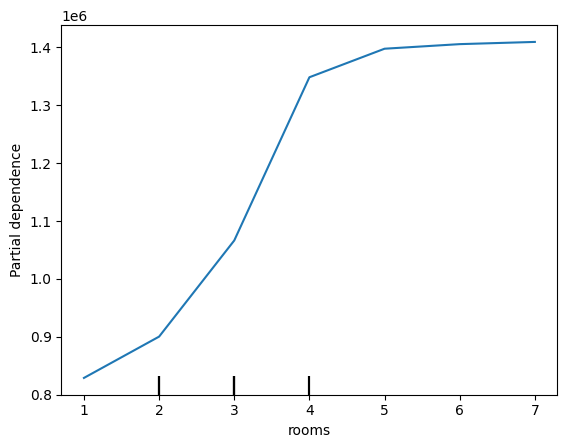

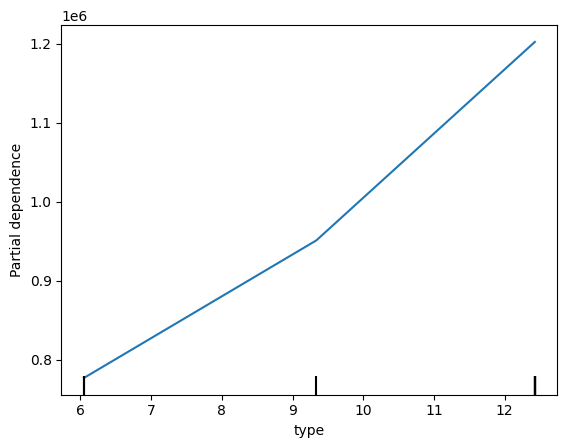

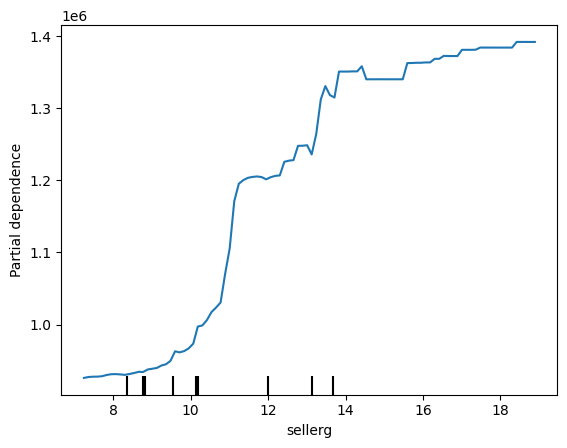

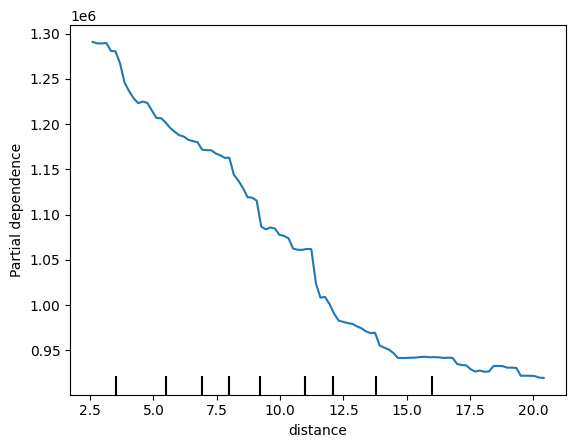

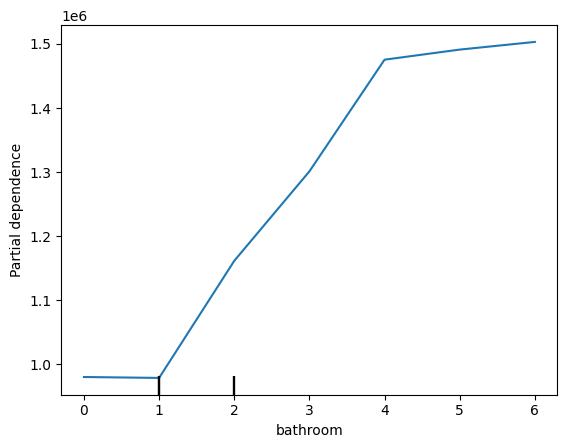

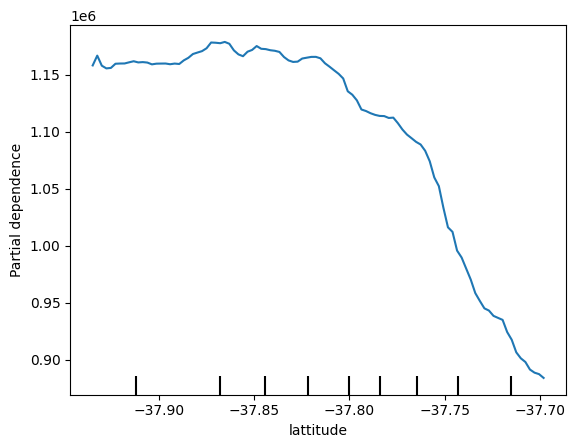

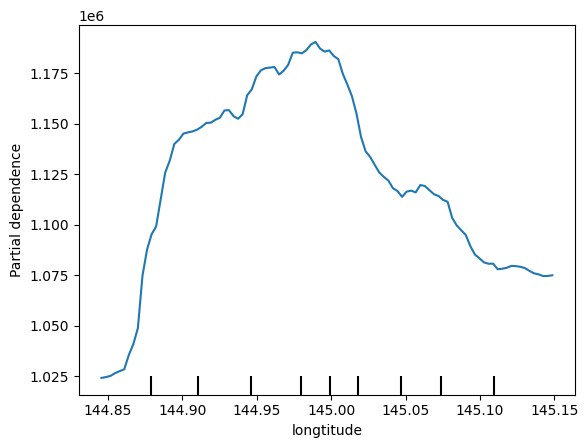

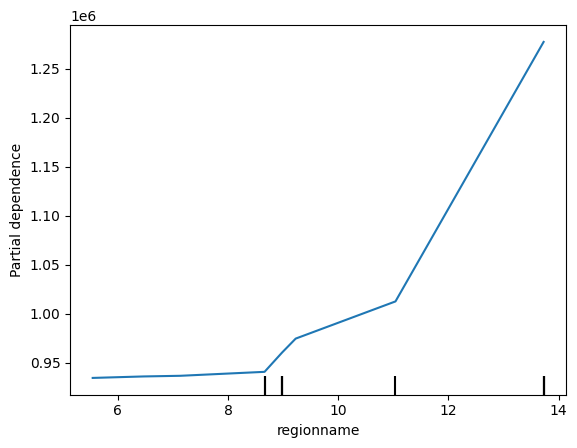

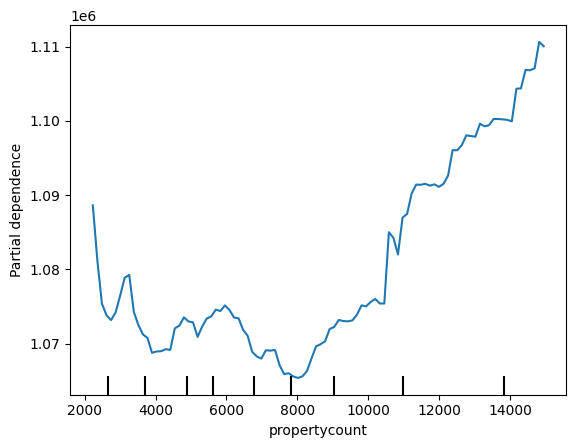

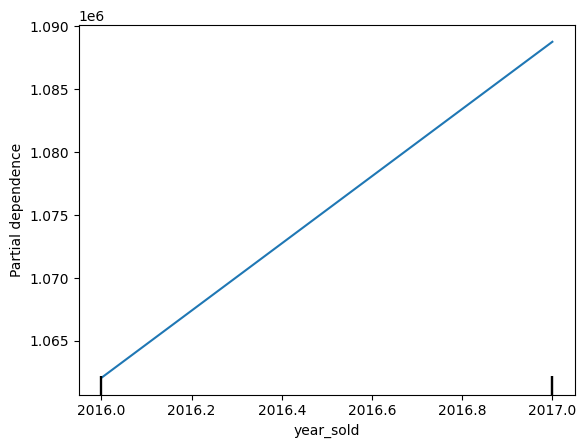

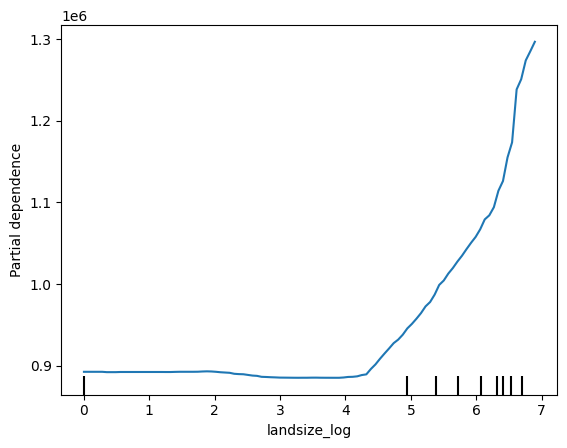

In [19]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay


for feature in test_X.columns:
    PartialDependenceDisplay.from_estimator(model, test_X, [feature])


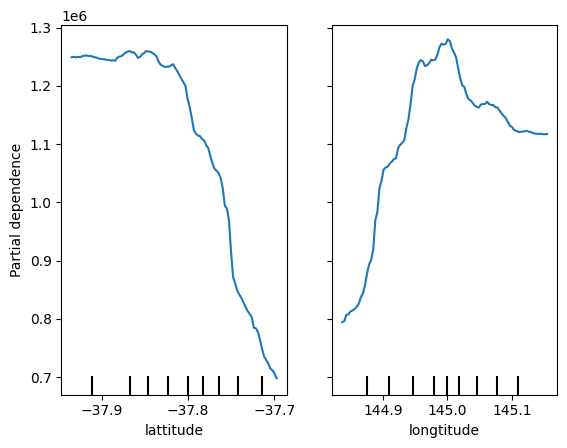

In [4]:

PartialDependenceDisplay.from_estimator(model, test_X, ['lattitude', 'longtitude'])

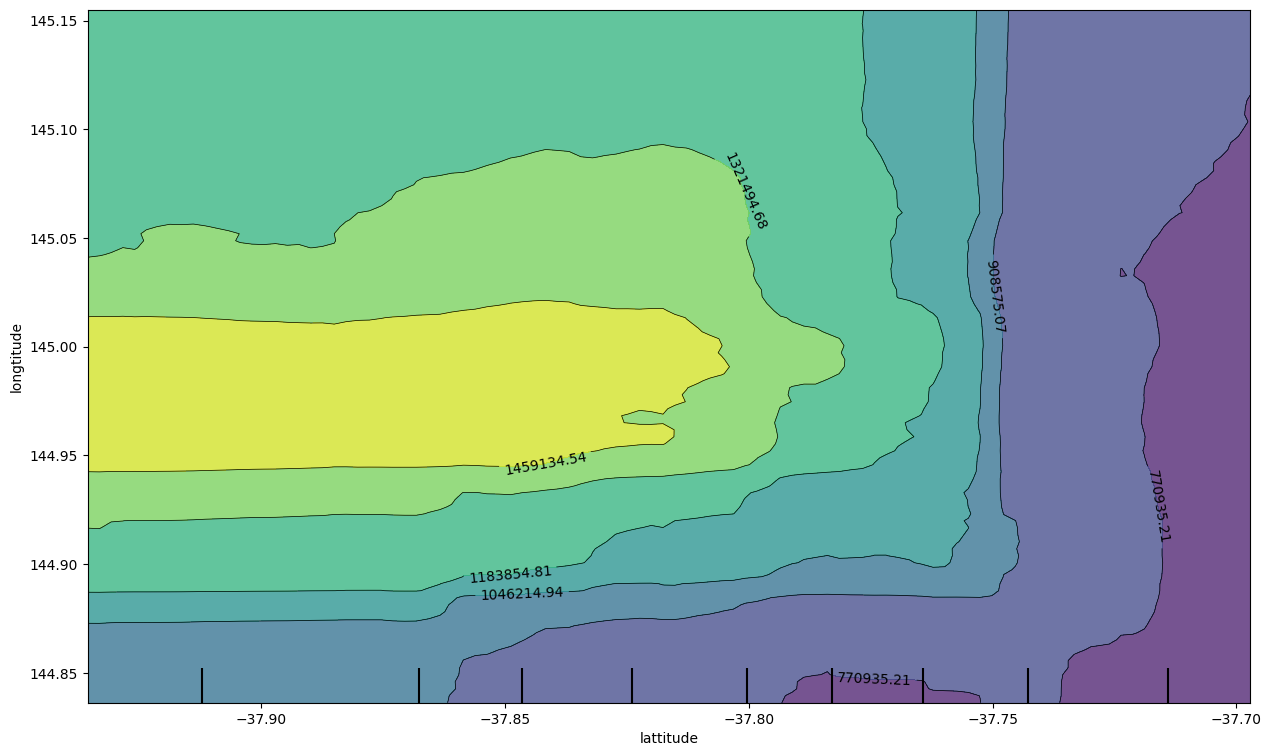

In [5]:
fig, ax = plt.subplots(figsize = (15, 9))
features = [('lattitude', 'longtitude')]
PartialDependenceDisplay.from_estimator(model, test_X, features, ax = ax)

### SHAP values

In [6]:
data_for_prediction = test_X.iloc[[10]]
model.predict(data_for_prediction)

array([1294962.4])

In [7]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)

In [8]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [9]:
row = 20
data_for_prediction = test_X.iloc[[row]]
model.predict(data_for_prediction)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [10]:
shap_values

array([[-1.86712397e+05,  4.50033383e+04, -6.28021188e+04,
        -1.65196917e+04, -7.51828601e+03, -1.45211596e+04,
         8.74409882e+04, -1.20247229e+04, -1.27567855e+05,
         2.82457646e+03,  4.83938789e+03, -2.46752727e+05,
         1.36013615e+02, -2.83981110e+02, -2.64331630e+02,
        -3.04147798e+02, -2.17952598e+02, -4.91372061e+02,
        -2.49204793e+00,  4.85807194e+01,  7.66142864e-01,
         9.52363697e+01, -3.23291735e+03, -3.82860291e+02,
        -7.63262153e+01, -6.96334901e+03, -2.08963596e+02,
        -2.90780819e+02,  4.56543529e+03, -2.51265998e+02,
         2.12758188e+02,  9.00763729e+01,  5.39529659e+02,
        -3.41617766e+02,  3.94816269e+01,  1.96779543e+02,
        -2.90600781e+01, -5.64415519e+02, -3.45692229e+02,
         2.20377985e+00]])

In [11]:
t1 = (shap_values/1000).astype(int).tolist()
df1 = pd.DataFrame(t1, columns = test_X.columns)
row = df1.iloc[0]
row[row!=0]

rooms               -186
distance              45
bathroom             -62
car                  -16
yearbuilt             -7
lattitude            -14
longtitude            87
year_sold            -12
landsize_log        -127
yearbuilt_present      2
t                      4
u                   -246
jellis                -3
marshall              -6
nelson                 4
Name: 0, dtype: int64

In [12]:
main_factors = row[row!=0]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


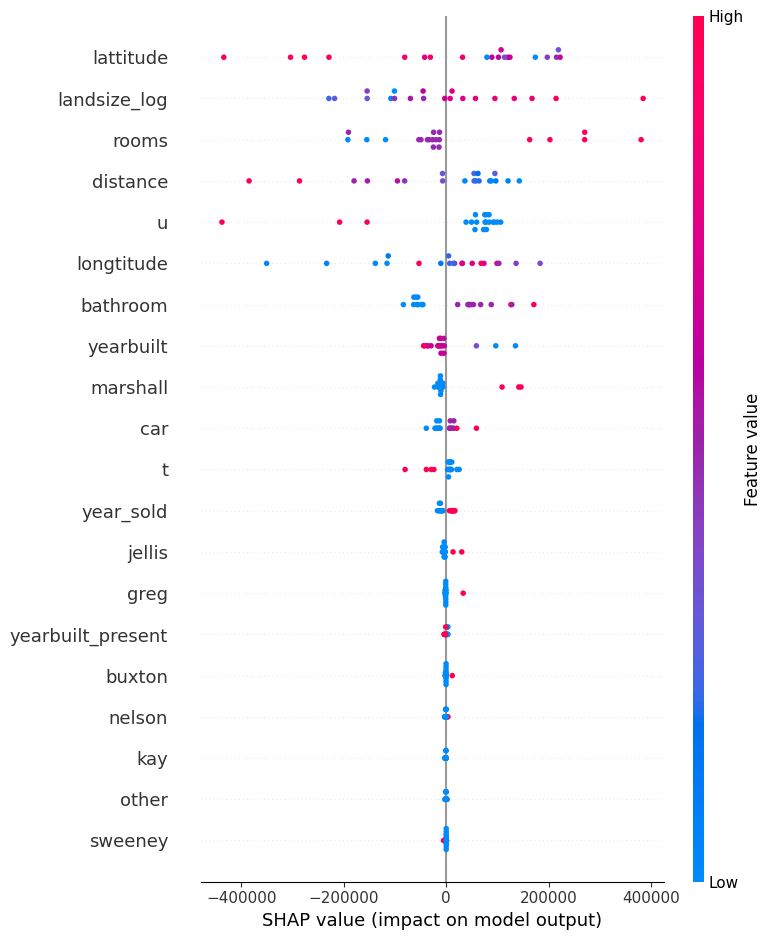

In [13]:
smal_X = test_X.iloc[:20]
shap_values_all = explainer.shap_values(smal_X)
shap.summary_plot(shap_values_all, smal_X)

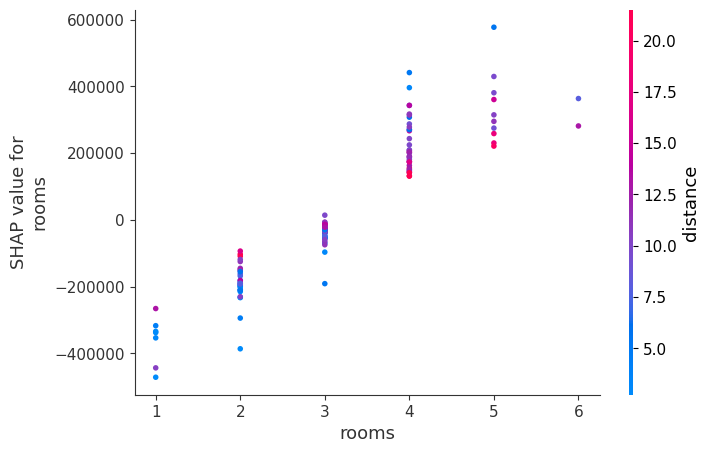

In [14]:
shap_values2 = explainer.shap_values(test_X.iloc[:150])
shap.dependence_plot("rooms", shap_values2, test_X[:150])

In [15]:
row = 20
data_for_prediction = test_X.iloc[[row]]
model.predict(data_for_prediction)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)


In [16]:
max_digits = len(
    str(
        abs(shap_values).astype(int).max()
        )
    )
div = 10**(max_digits-2)

feat_weights = pd.DataFrame(
                (shap_values/div).astype(int).tolist(), 
                columns=X.columns)
feat_weights

,rooms,distance,bathroom,car,yearbuilt,lattitude,longtitude,year_sold,landsize_log,yearbuilt_present,...,other,raine,ray,rt,stockdale,sweeney,village,williams,woodards,ypa
0,-18,4,-6,-1,0,-1,8,-1,-12,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

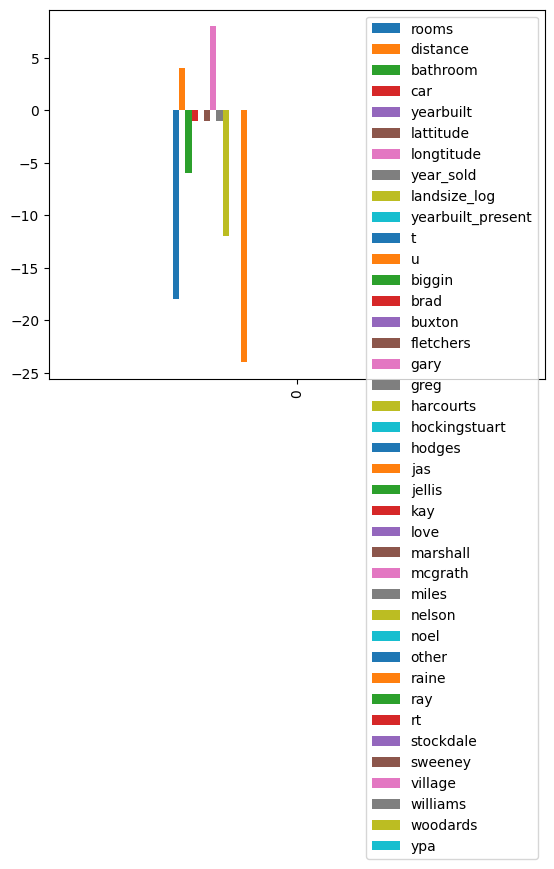

In [17]:
feat_weights.plot(kind='bar')

In [18]:
import seaborn as sns

In [19]:
feat_weights = feat_weights.loc[:, (feat_weights!=0).any(axis=0)]
feat_weights

,rooms,distance,bathroom,car,lattitude,longtitude,year_sold,landsize_log,u
0,-18,4,-6,-1,-1,8,-1,-12,-24


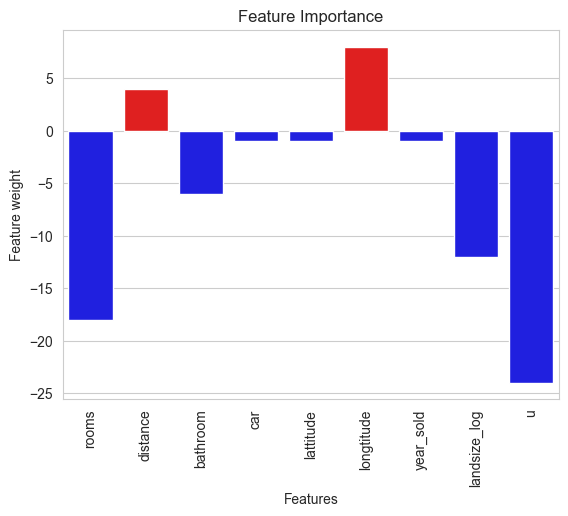

In [20]:
sns.set_style("whitegrid")
ax = sns.barplot(data=feat_weights, palette=['r' if x >= 0 else 'b' for x in feat_weights.values[0]])
ax.set_title("Feature Importance")
ax.set_xlabel("Features")
ax.set_ylabel("Feature weight")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()
